Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [29]:
# 画图用
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [194]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [197]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [198]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

针对2_fullyconnected里面用过的logistic和神经网络， 用L2泛化，可以提高test精确度。我们先从logistic开始。由于L2泛化会引入一个新的参数lambda，我们引入一个新的tf变量。

In [56]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  reg_lambda = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + reg_lambda * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [82]:
def train_with_l2_loss(reg_lambda_value, processing = False):
  num_steps = 3001
  
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized. rain on lambda parameter = %.5lf" % reg)
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg_lambda: reg_lambda_value}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (processing and step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    return accuracy(valid_prediction.eval(), valid_labels)


In [83]:
train_with_l2_loss(0.1, True)

Initialized. rain on lambda parameter = 0.07278
Minibatch loss at step 0: 314.507751
Minibatch accuracy: 9.4%
Validation accuracy: 12.2%
Minibatch loss at step 500: 1.160237
Minibatch accuracy: 74.2%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 1.165943
Minibatch accuracy: 74.2%
Validation accuracy: 78.5%
Minibatch loss at step 1500: 1.058612
Minibatch accuracy: 75.8%
Validation accuracy: 78.4%
Minibatch loss at step 2000: 0.957208
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 1.068618
Minibatch accuracy: 77.3%
Validation accuracy: 80.4%
Minibatch loss at step 3000: 0.986193
Minibatch accuracy: 80.5%
Validation accuracy: 77.1%
Test accuracy: 81.8%


77.099999999999994

又引入了一个超参数， 不知道该设置多少，随便设置一个值0.1， 发现效果并没有提升， 反而下降了。我们搜索一下， 看哪个参数比较好。

In [89]:
reg_val = [pow(10, i) for i in np.arange(-4, -1, 0.477)] # 按Andrew Ng大神的经验， 调参数时候3倍3倍的增长， 大概就是0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1...这样调
accuracy_val = []

for reg in reg_val:
  valid_accuracy = train_with_l2_loss(reg)
  accuracy_val.append(valid_accuracy) # 这里要用valid_dataset不能用test_dataset， 否则可能造成overfitting。valid_dataset的作用就是拿来调超参数的
        
print('tune hyper paramer reg_lambda over.')        

Initialized. rain on lambda parameter = 0.00010
Test accuracy: 90.1%
Initialized. rain on lambda parameter = 0.00030
Test accuracy: 89.6%
Initialized. rain on lambda parameter = 0.00090
Test accuracy: 90.8%
Initialized. rain on lambda parameter = 0.00270
Test accuracy: 91.3%
Initialized. rain on lambda parameter = 0.00809
Test accuracy: 89.1%
Initialized. rain on lambda parameter = 0.02427
Test accuracy: 86.7%
Initialized. rain on lambda parameter = 0.07278
Test accuracy: 83.8%
tune hyper paramer reg_lambda over.


7 7


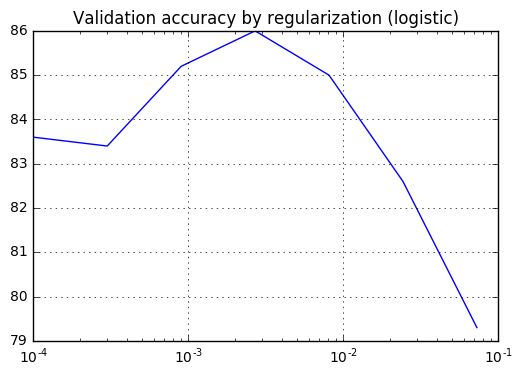

In [91]:
plt.semilogx(reg_val, accuracy_val)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

可以发现reg_lambda在0.001左右的时候最大，test accuracy在87%左右，确实有所提升。

In [85]:
train_with_l2_loss(0.001, True)

Initialized. rain on lambda parameter = 0.07278
Minibatch loss at step 0: 23.721201
Minibatch accuracy: 8.6%
Validation accuracy: 15.6%
Minibatch loss at step 500: 2.869463
Minibatch accuracy: 76.6%
Validation accuracy: 77.5%
Minibatch loss at step 1000: 1.683140
Minibatch accuracy: 78.1%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 0.923806
Minibatch accuracy: 88.3%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 0.764704
Minibatch accuracy: 86.7%
Validation accuracy: 81.8%
Minibatch loss at step 2500: 0.827983
Minibatch accuracy: 82.0%
Validation accuracy: 82.2%
Minibatch loss at step 3000: 0.622134
Minibatch accuracy: 87.5%
Validation accuracy: 82.3%
Test accuracy: 86.5%


82.299999999999997

下面我们看看对于有一层隐藏层的神经网络，时候有效果。

In [87]:
batch_size = 128
num_of_hidden_layer = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  reg_lambda = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_of_hidden_layer]))
  biases1 = tf.Variable(tf.zeros([num_of_hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  train_hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(train_hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
        reg_lambda * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_hidden_layer, weights2) + biases2)
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer, weights2) + biases2)

In [88]:
train_with_l2_loss(0.1, True)

Initialized. rain on lambda parameter = 0.07278
Minibatch loss at step 0: 31864.312500
Minibatch accuracy: 7.0%
Validation accuracy: 37.0%
Minibatch loss at step 500: 1.473051
Minibatch accuracy: 75.0%
Validation accuracy: 80.4%
Minibatch loss at step 1000: 1.453134
Minibatch accuracy: 76.6%
Validation accuracy: 81.1%
Minibatch loss at step 1500: 1.370838
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 1.279009
Minibatch accuracy: 81.2%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 1.363197
Minibatch accuracy: 78.9%
Validation accuracy: 80.7%
Minibatch loss at step 3000: 1.339753
Minibatch accuracy: 77.3%
Validation accuracy: 77.3%
Test accuracy: 81.6%


77.299999999999997

也是将超参数reg_lambda随便设置一个值0.1， 可以看到，跟之前相比(90%)，test accuracy也是降低了。同样， 我们还是来搜索一下reg_lambda看看那个能让valid_accuracy最高。

In [90]:
reg_val = [pow(10, i) for i in np.arange(-4, -1, 0.477)] # 按Andrew Ng大神的经验， 调参数时候3倍3倍的增长， 大概就是0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1...这样调
accuracy_val = []

for reg in reg_val:
  valid_accuracy = train_with_l2_loss(reg)
  accuracy_val.append(valid_accuracy) # 这里要用valid_dataset不能用test_dataset， 否则可能造成overfitting。valid_dataset的作用就是拿来调超参数的
        
print('tune hyper paramer reg_lambda over.')   

Initialized. rain on lambda parameter = 0.00010
Test accuracy: 88.9%
Initialized. rain on lambda parameter = 0.00030
Test accuracy: 88.6%
Initialized. rain on lambda parameter = 0.00090
Test accuracy: 91.4%
Initialized. rain on lambda parameter = 0.00270
Test accuracy: 91.0%
Initialized. rain on lambda parameter = 0.00809
Test accuracy: 89.4%
Initialized. rain on lambda parameter = 0.02427
Test accuracy: 86.5%
Initialized. rain on lambda parameter = 0.07278
Test accuracy: 83.9%
tune hyper paramer reg_lambda over.


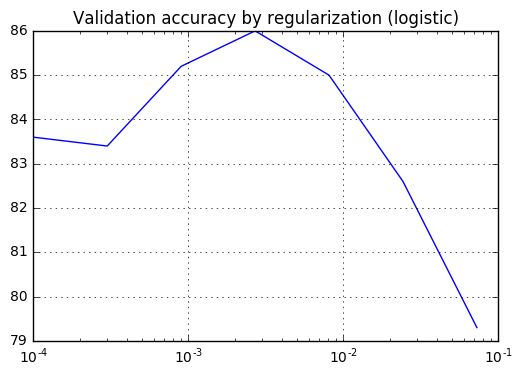

In [92]:
plt.semilogx(reg_val, accuracy_val)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

跟logistic时候几乎一样， 也是在0.0015多一点的地方valid_accuracy最高， 对应的test_accuracy为92.0%。

In [94]:
train_with_l2_loss(0.0015)

Initialized. rain on lambda parameter = 0.07278
Test accuracy: 92.0%


86.5

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

我们看看如果没有regularization，而训练数据又很少的话，会怎样的overfitting！

In [137]:
batch_size = 128
num_of_hidden_layer = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_of_hidden_layer]))
  biases1 = tf.Variable(tf.zeros([num_of_hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  train_hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(train_hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))# + 0.31 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_hidden_layer, weights2) + biases2)
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer, weights2) + biases2)

In [138]:
num_steps = 20

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = 10 # 这里写为固定值，说明batch_data每次都是取的同一批， 总共只有batch_size个数据在训练， 所以很容易overfitting
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 336.788269
Minibatch accuracy: 8.6%
Validation accuracy: 40.9%
Minibatch loss at step 2: 989.343384
Minibatch accuracy: 45.3%
Validation accuracy: 32.6%
Minibatch loss at step 4: 472.988098
Minibatch accuracy: 60.9%
Validation accuracy: 56.5%
Minibatch loss at step 6: 7.091978
Minibatch accuracy: 97.7%
Validation accuracy: 67.0%
Minibatch loss at step 8: 0.996944
Minibatch accuracy: 99.2%
Validation accuracy: 67.5%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Minibatch loss at step 12: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Minibatch loss at step 18: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Test accuracy: 71.1%


由于有太多的参数而只有少量数据，又没有regularization，我们可以看到train_accuracy达到100%了，valid_accuracy则维持在67%。

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [139]:
batch_size = 128
num_of_hidden_layer = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_of_hidden_layer]))
  biases1 = tf.Variable(tf.zeros([num_of_hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  train_hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop_out = tf.nn.dropout(train_hidden_layer, 0.5)
  logits = tf.matmul(drop_out, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_hidden_layer, weights2) + biases2)
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer, weights2) + biases2)

In [140]:
num_steps = 20

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = 10 # 这里写为固定值，说明batch_data每次都是取的同一批， 总共只有batch_size个数据在训练， 所以很容易overfitting
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 536.540710
Minibatch accuracy: 14.8%
Validation accuracy: 38.3%
Minibatch loss at step 2: 1040.059326
Minibatch accuracy: 35.2%
Validation accuracy: 50.4%
Minibatch loss at step 4: 380.764893
Minibatch accuracy: 68.0%
Validation accuracy: 61.8%
Minibatch loss at step 6: 34.103321
Minibatch accuracy: 90.6%
Validation accuracy: 68.6%
Minibatch loss at step 8: 0.506745
Minibatch accuracy: 99.2%
Validation accuracy: 71.4%
Minibatch loss at step 10: 3.786833
Minibatch accuracy: 98.4%
Validation accuracy: 72.9%
Minibatch loss at step 12: 0.329448
Minibatch accuracy: 98.4%
Validation accuracy: 73.3%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.5%
Minibatch loss at step 18: 1.011385
Minibatch accuracy: 98.4%
Validation accuracy: 72.7%
Test accuracy: 75.5%


可以看到有了dropout后，train_accuracy很难达到100%了。并且valid_accuracy和test_accuracy也提高了5%左右。 大家可以试试不同的dropout参数会有什么结果，另外大家有兴趣的也可以测试一下L2 regularization的效果怎样。

据说dropout是state-of-the-art的regularization技术， 如果dropout都没用， 估计是你的神经网络太复杂而数据太少了。

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [166]:
batch_size = 128
num_of_hidden_layer1 = 1024
num_of_hidden_layer2 = 100
reg_lambda = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)  # count the number of steps taken.
  
  # Variables.
  # 参数初始化相当重要！这里如果不这样设置stddev的话几乎训练不动， 简单解释一下理由：
  # 如果只是简单的标准正太分布，大量的小参数累加起来会的到一个绝对值很大的数， 而logistic(x) = 1 / (1 + exp(-x))
  # 在x绝对值很大的时候要么等于1（x为很大的正数，如10）要么等于0（x为很小的负数，比如-10），在那些点导数几乎为0
  # 所以很难训练。 而这样设置参数的stddev之后，大量参数累加起来之后大概是符合标准正太分布的，所以logistic(x)在这些点比较容易训练。
  weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_of_hidden_layer1],
      stddev = np.sqrt(2.0 / (image_size * image_size))))
  biases1 = tf.Variable(tf.zeros([num_of_hidden_layer1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer1, num_of_hidden_layer2], 
                       stddev = np.sqrt(2.0 / num_of_hidden_layer1)))
  biases2 = tf.Variable(tf.zeros([num_of_hidden_layer2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer2, num_labels],
                       stddev = np.sqrt(2.0 / num_of_hidden_layer2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  
  # Training computation.
  train_hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  train_hidden_layer2 = tf.nn.relu(tf.matmul(train_hidden_layer1, weights2) + biases2)
#   drop_out = tf.nn.dropout(train_hidden_layer, 0.5)
#   logits = tf.matmul(drop_out, weights2) + biases2
  logits = tf.matmul(train_hidden_layer2, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
        reg_lambda * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  decay_step = 1000
  decay_rate = 0.65
  learning_rate = tf.train.exponential_decay(0.5, global_step, decay_step, decay_rate, staircase = True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_layer1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_hidden_layer2 = tf.nn.relu(tf.matmul(valid_hidden_layer1, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_layer2, weights3) + biases3)
  test_hidden_layer1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_hidden_layer2 = tf.nn.relu(tf.matmul(test_hidden_layer1, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer2, weights3) + biases3)

In [167]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.237680
Minibatch accuracy: 10.9%
Validation accuracy: 41.9%
Minibatch loss at step 500: 0.955061
Minibatch accuracy: 90.6%
Validation accuracy: 86.1%
Minibatch loss at step 1000: 0.742591
Minibatch accuracy: 93.0%
Validation accuracy: 86.9%
Minibatch loss at step 1500: 0.507514
Minibatch accuracy: 97.7%
Validation accuracy: 86.4%
Minibatch loss at step 2000: 0.392957
Minibatch accuracy: 99.2%
Validation accuracy: 87.0%
Minibatch loss at step 2500: 0.387412
Minibatch accuracy: 96.9%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.306398
Minibatch accuracy: 99.2%
Validation accuracy: 87.5%
Minibatch loss at step 3500: 0.304873
Minibatch accuracy: 99.2%
Validation accuracy: 87.7%
Minibatch loss at step 4000: 0.284234
Minibatch accuracy: 99.2%
Validation accuracy: 87.0%
Minibatch loss at step 4500: 0.261848
Minibatch accuracy: 100.0%
Validation accuracy: 86.8%
Minibatch loss at step 5000: 0.260522
Minibatch accuracy: 99.2%
Validation accura

我们来试试用dropout呢。

In [199]:
batch_size = 128
num_of_hidden_layer1 = 1024
num_of_hidden_layer2 = 256
num_of_hidden_layer3 = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)  # count the number of steps taken.
  batch = tf.Variable(0)
  
  # Variables.
  # 参数初始化相当重要！这里如果不这样设置stddev的话几乎训练不动， 简单解释一下理由：
  # 如果只是简单的标准正太分布，大量的小参数累加起来会的到一个绝对值很大的数， 而logistic(x) = 1 / (1 + exp(-x))
  # 在x绝对值很大的时候要么等于1（x为很大的正数，如10）要么等于0（x为很小的负数，比如-10），在那些点导数几乎为0
  # 所以很难训练。 而这样设置参数的stddev之后，大量参数累加起来之后大概是符合标准正太分布的，所以logistic(x)在这些点比较容易训练。
  weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_of_hidden_layer1],
      stddev = np.sqrt(2.0 / (image_size * image_size))))
  biases1 = tf.Variable(tf.zeros([num_of_hidden_layer1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer1, num_of_hidden_layer2], 
                       stddev = np.sqrt(2.0 / num_of_hidden_layer1)))
  biases2 = tf.Variable(tf.zeros([num_of_hidden_layer2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer2, num_of_hidden_layer3], 
                       stddev = np.sqrt(2.0 / num_of_hidden_layer2)))
  biases3 = tf.Variable(tf.zeros([num_of_hidden_layer3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_of_hidden_layer3, num_labels],
                       stddev = np.sqrt(2.0 / num_of_hidden_layer3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  
  # Training computation.
  train_hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  dropout1 = tf.nn.dropout(train_hidden_layer1, 0.5)
  train_hidden_layer2 = tf.nn.relu(tf.matmul(dropout1, weights2) + biases2)
  dropout2 = tf.nn.dropout(train_hidden_layer2, 0.5)
  train_hidden_layer3 = tf.nn.relu(tf.matmul(dropout2, weights3) + biases3)
  dropout3 = tf.nn.dropout(train_hidden_layer3, 0.5)
  logits = tf.matmul(dropout3, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
  
  # Optimizer.
  # https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
  decay_step = 4000
  decay_rate = 0.65
  learning_rate = tf.train.exponential_decay(0.5, global_step, decay_step, decay_rate, staircase = True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_layer1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_hidden_layer2 = tf.nn.relu(tf.matmul(valid_hidden_layer1, weights2) + biases2)
  valid_hidden_layer3 = tf.nn.relu(tf.matmul(valid_hidden_layer2, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_layer3, weights4) + biases4)
  test_hidden_layer1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_hidden_layer2 = tf.nn.relu(tf.matmul(test_hidden_layer1, weights2) + biases2)
  test_hidden_layer3 = tf.nn.relu(tf.matmul(test_hidden_layer2, weights3) + biases3)    
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer3, weights4) + biases4)

In [201]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.661277
Minibatch accuracy: 11.7%
Validation accuracy: 23.3%
Minibatch loss at step 500: 0.693966
Minibatch accuracy: 80.5%
Validation accuracy: 83.9%
Minibatch loss at step 1000: 0.480082
Minibatch accuracy: 84.4%
Validation accuracy: 85.0%
Minibatch loss at step 1500: 0.566766
Minibatch accuracy: 85.9%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 0.367176
Minibatch accuracy: 87.5%
Validation accuracy: 86.2%
Minibatch loss at step 2500: 0.519465
Minibatch accuracy: 84.4%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 0.648941
Minibatch accuracy: 83.6%
Validation accuracy: 86.5%
Minibatch loss at step 3500: 0.350502
Minibatch accuracy: 89.8%
Validation accuracy: 86.8%
Minibatch loss at step 4000: 0.463804
Minibatch accuracy: 86.7%
Validation accuracy: 86.8%
Minibatch loss at step 4500: 0.375013
Minibatch accuracy: 88.3%
Validation accuracy: 87.7%
Minibatch loss at step 5000: 0.498090
Minibatch accuracy: 85.9%
Validation accurac

得到的数据离97%差了不少，试了各种参数都上不去，只能到93%。 仔细对比我只选择了20000个train_dataset并且没有清洗数据数据，可见数据的重要性！正如那句话说的：
```
It's not who has the best algorithm that wins. It's who has the most data.
```

我把train_dataset放成20w条，得到的结果是：95.3%。由于清洗数据之后duplicate的只有1000多条，占整个20w条的比例很小，所以我估计结果误差很小，在自己的mac上跑deep NN，CPU飙到600%+，听着风扇狂转，很是心疼，所以我就放弃了尝试，有兴趣的可以自己试一下。